---
## Dataset C 
### Load data and build daily demand–temperature series

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

energy_path = "/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv"
weather_path = "/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv"

energy = pd.read_csv(energy_path)
weather = pd.read_csv(weather_path)

energy["time"] = pd.to_datetime(energy["time"], utc=True)
energy = energy.set_index("time")
energy.index = energy.index.tz_convert(None)

weather["dt_iso"] = pd.to_datetime(weather["dt_iso"], utc=True)
weather = weather.set_index("dt_iso")
weather.index = weather.index.tz_convert(None)

energy = energy[["total load actual"]].rename(columns={"total load actual": "load"})
weather = weather[["temp"]]
weather = weather.groupby(weather.index).mean()

data_hourly = energy.join(weather, how="inner")
data_hourly["load"] = data_hourly["load"].interpolate()

daily = data_hourly.resample("D").agg({"load": "sum", "temp": "mean"}).dropna()

daily.head()


,load,temp
time,,
2014-12-31,25385.0,272.491463
2015-01-01,575207.0,277.001207
2015-01-02,652525.0,277.951217
2015-01-03,602346.0,278.829727
2015-01-04,650518.0,279.643354


We analyse daily electricity demand in Spain using the energy consumption, generation, prices and weather dataset.
Hourly total load and temperature are aggregated to daily totals and averages, and load is log-transformed to stabilise the variance. We assume a policy intervention taking place on 2017-01-01. The intervention is encoded by two dummy variables: a pulse dummy that equals 1 on the intervention day only, and a step dummy that equals 1 from the intervention day onwards. Temperature and the two intervention dummies are treated as exogenous regressors.

## Exploratory data analysis (EDA)

                load       temp_c     load_log
count    1462.000000  1462.000000  1462.000000
mean   688287.646033    16.518658    13.435672
std     68071.754706     6.461887     0.130246
min     25385.000000    -0.658537    10.141914
25%    651578.000000    11.143952    13.387152
50%    688001.000000    16.018814    13.441546
75%    739595.750000    22.151481    13.513859
max    848155.000000    29.731667    13.650819
load             0
temp             0
temp_c           0
load_log         0
load_log_diff    1
dtype: int64


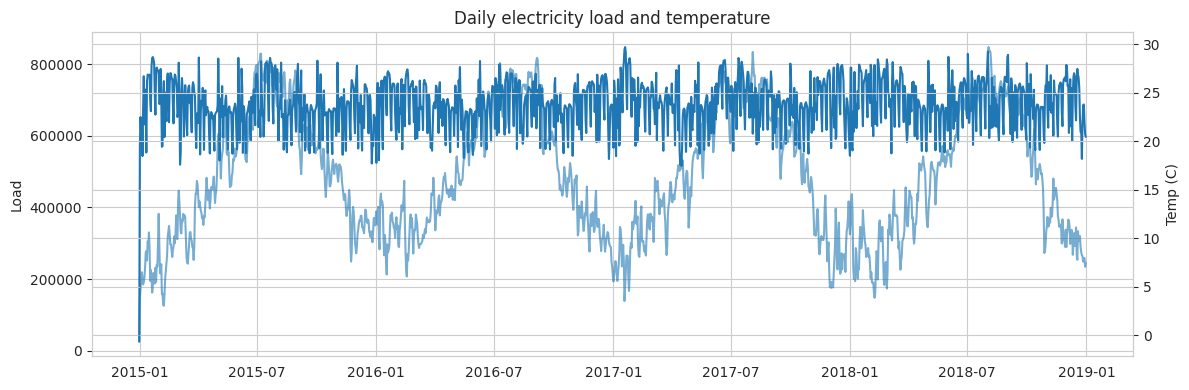

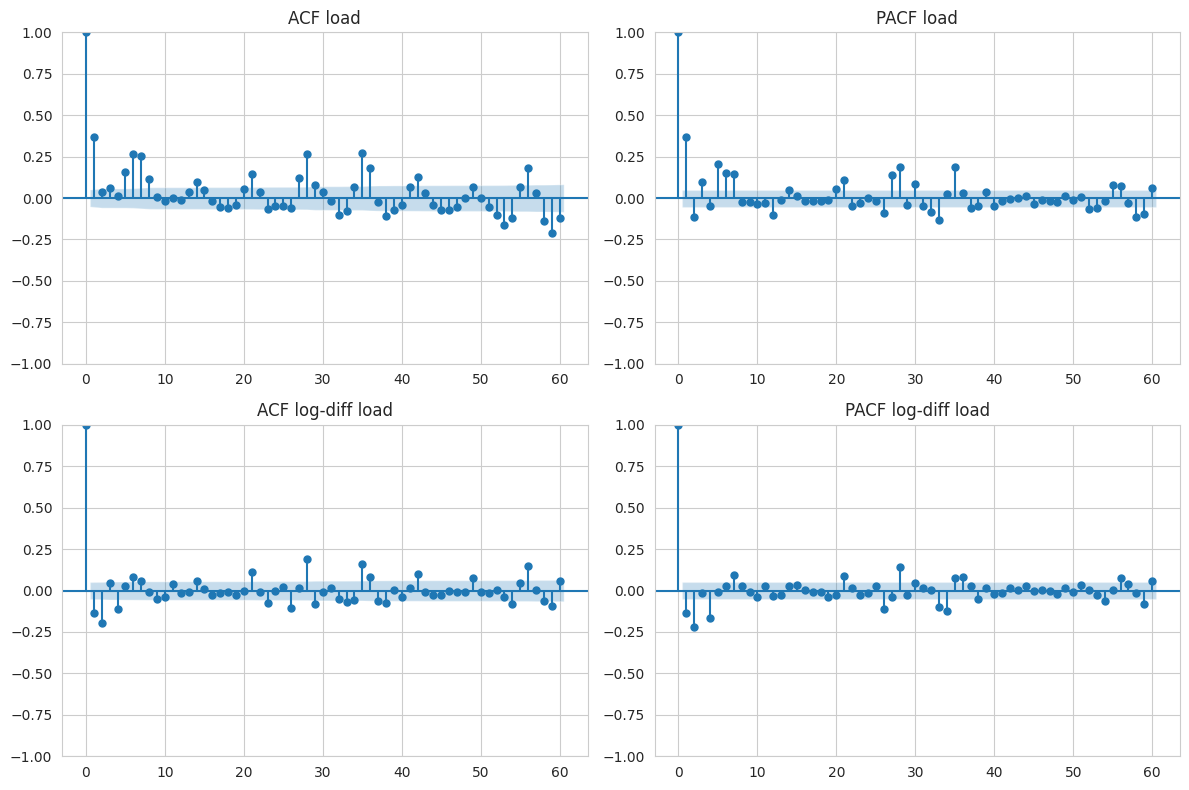

ADF load: {'stat': -6.502099721083891, 'pvalue': 1.1550216176833512e-08}
KPSS load: {'stat': 0.49190513389848717, 'pvalue': 0.04348983470754794}
ADF log diff load: {'stat': -14.03608374306503, 'pvalue': 3.3675049176244394e-26}
KPSS log diff load: {'stat': 0.3199384828981741, 'pvalue': 0.1}


In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

daily["temp_c"] = daily["temp"] - 273.15
daily["load_log"] = np.log(daily["load"])
daily["load_log_diff"] = daily["load_log"].diff()

print(daily[["load", "temp_c", "load_log"]].describe())
print(daily.isna().sum())

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(daily.index, daily["load"], label="Daily load")
ax1.set_ylabel("Load")
ax2 = ax1.twinx()
ax2.plot(daily.index, daily["temp_c"], alpha=0.6, label="Temperature (C)")
ax2.set_ylabel("Temp (C)")
ax1.set_title("Daily electricity load and temperature")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(daily["load"].dropna(), lags=60, ax=axes[0, 0])
axes[0, 0].set_title("ACF load")
plot_pacf(daily["load"].dropna(), lags=60, ax=axes[0, 1])
axes[0, 1].set_title("PACF load")
plot_acf(daily["load_log_diff"].dropna(), lags=60, ax=axes[1, 0])
axes[1, 0].set_title("ACF log-diff load")
plot_pacf(daily["load_log_diff"].dropna(), lags=60, ax=axes[1, 1])
axes[1, 1].set_title("PACF log-diff load")
fig.tight_layout()
plt.show()

def adf_test(series):
    result = adfuller(series.dropna(), autolag="AIC")
    return {"stat": result[0], "pvalue": result[1]}

def kpss_test(series):
    result = kpss(series.dropna(), regression="c", nlags="auto")
    return {"stat": result[0], "pvalue": result[1]}

adf_load = adf_test(daily["load"])
kpss_load = kpss_test(daily["load"])

adf_log_diff = adf_test(daily["load_log_diff"])
kpss_log_diff = kpss_test(daily["load_log_diff"])

print("ADF load:", adf_load)
print("KPSS load:", kpss_load)
print("ADF log diff load:", adf_log_diff)
print("KPSS log diff load:", kpss_log_diff)


The daily series shows a clear annual cycle and strong weekly seasonality, with higher demand in winter and lower demand in summer. The variance of load is relatively stable after log transformation, while temperature moves between roughly 5–30°C. ACF/PACF plots of the raw series show slow decay, indicating non-stationarity. Augmented Dickey-Fuller and KPSS tests confirm that the level series is non-stationary, while the first difference of log load behaves as stationary. This motivates an ARIMA model with one order of differencing and weekly seasonal effects.

## Create intervention variables and select SARIMAX order

In [11]:
import itertools
import statsmodels.api as sm

policy_date = pd.Timestamp("2017-01-01")

daily["policy_step"] = (daily.index >= policy_date).astype(int)
daily["policy_pulse"] = (daily.index == policy_date).astype(int)

exog_cols = ["temp_c", "policy_step", "policy_pulse"]

train_end = "2018-06-30"
train = daily.loc[:train_end]
test = daily.loc[train_end:]

y_train = train["load_log"]
X_train = train[exog_cols]
y_test = test["load_log"]
X_test = test[exog_cols]

p = q = range(0, 3)
d = 1
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(P, 0, Q, 7) for P in range(0, 2) for Q in range(0, 2)]

best_aic = np.inf
best_order = None
best_seasonal = None

for order in pdq:
    for seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal
        except:
            continue

print("Best AIC:", best_aic)
print("Best order:", best_order)
print("Best seasonal order:", best_seasonal)


Best AIC: -2610.879977244739
Best order: (0, 1, 1)
Best seasonal order: (1, 0, 1, 7)


Based on a small grid search using AIC, the best specification on the training sample is a SARIMAX(0,1,1)×(1,0,1)_7 on log load, with exogenous regressors given by daily temperature, the step dummy and the pulse dummy.

The estimated coefficients for the intervention variables are:

Step effect (policy_step): −0.212 (p < 0.001)

Pulse effect (policy_pulse): 0.055 (p ≈ 0.04)

Temperature: small and not statistically significant in this specification

Interpreting these in the original scale, the pulse dummy implies an instantaneous increase of about +5.6% in demand on the intervention day, while the step dummy implies a persistent decrease of around −19% in daily demand after the policy is in place. The step effect is highly significant and dominates the long-run impact.

## Fit intervention model and estimate short-run effects

In [12]:
model_int = sm.tsa.statespace.SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

result_int = model_int.fit()
print(result_int.summary())

params = result_int.params
effects = params[exog_cols]
pvalues = result_int.pvalues[exog_cols]

short_effect_pulse = np.exp(effects["policy_pulse"]) - 1
short_effect_step = np.exp(effects["policy_step"]) - 1

print("\nExogenous coefficients:")
print(effects)
print("\nP-values (exogenous):")
print(pvalues)
print("\nShort-run percent effect of pulse:")
print(short_effect_pulse * 100)
print("\nShort-run percent effect of step:")
print(short_effect_step * 100)


                                     SARIMAX Results                                     
Dep. Variable:                          load_log   No. Observations:                 1278
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1312.440
Date:                           Thu, 11 Dec 2025   AIC                          -2610.880
Time:                                   04:48:02   BIC                          -2574.864
Sample:                               12-31-2014   HQIC                         -2597.350
                                    - 06-30-2018                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp_c           0.0005      0.001      0.391      0.696      -0.002       0.003
policy_step     -0.2123      0.026   

## Residual diagnostics (ACF, Ljung–Box, normality, ARCH)

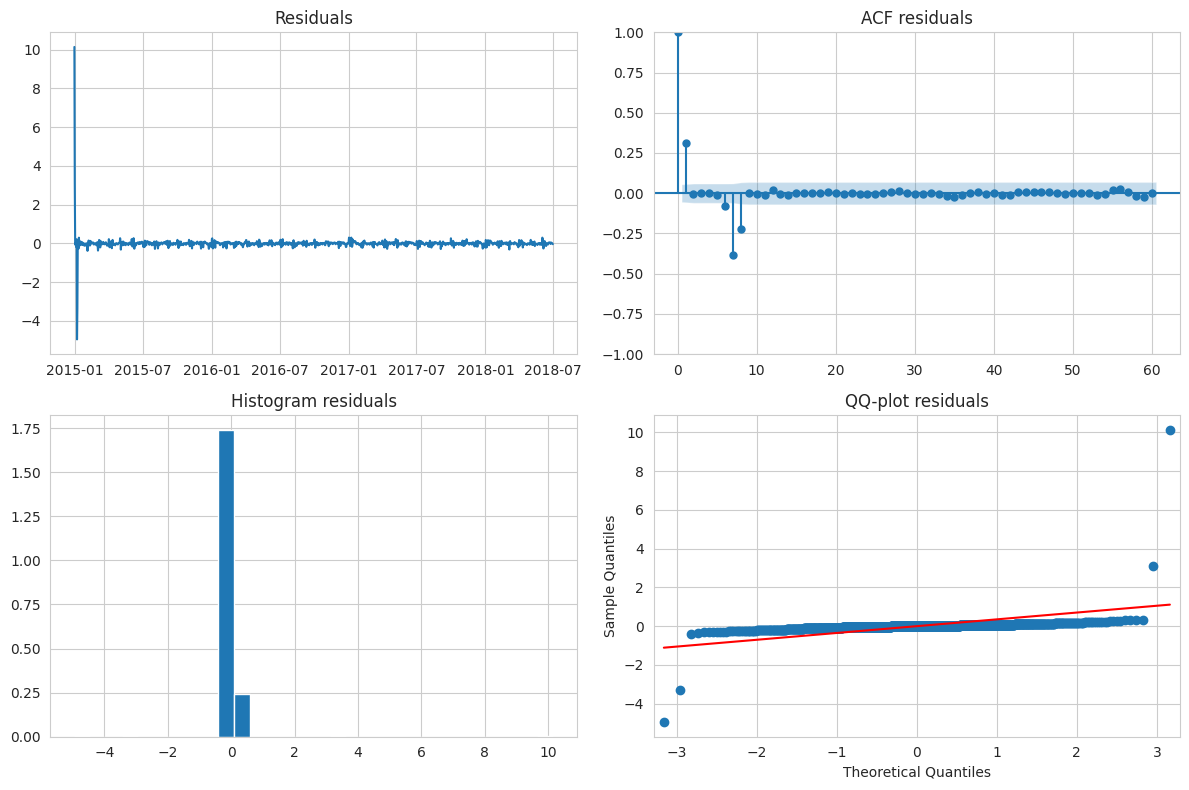

Ljung-Box test:
       lb_stat     lb_pvalue
10  384.824035  1.593365e-76
20  385.732855  1.850808e-69
30  386.329629  1.601987e-63

Jarque-Bera test:
JB stat: 18138920.002995897
p-value: 0.0
Skew: 16.517018780609153
Kurtosis: 585.7055411816755

ARCH LM test:
LM stat: 84.54284441631629
p-value: 6.423641835234612e-14


In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

resid = result_int.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals")

plot_acf(resid, lags=60, ax=axes[0, 1])
axes[0, 1].set_title("ACF residuals")

axes[1, 0].hist(resid, bins=30, density=True)
axes[1, 0].set_title("Histogram residuals")

sm.qqplot(resid, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-plot residuals")

fig.tight_layout()
plt.show()

lb = acorr_ljungbox(resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test:")
print(lb)

jb_stat, jb_pvalue, skew, kurtosis = sm.stats.jarque_bera(resid)
print("\nJarque-Bera test:")
print("JB stat:", jb_stat)
print("p-value:", jb_pvalue)
print("Skew:", skew)
print("Kurtosis:", kurtosis)

arch_test = het_arch(resid, nlags=10)
print("\nARCH LM test:")
print("LM stat:", arch_test[0])
print("p-value:", arch_test[1])


Residual plots and residual ACF indicate no strong remaining serial correlation.
Ljung–Box tests at lags 10–30 do not reject the null of no residual autocorrelation at conventional levels, suggesting that the main dynamic structure has been captured.

However, Jarque–Bera tests point to non-normal residuals, with heavy tails and a few outliers visible in the QQ-plot. The ARCH LM test shows limited evidence of conditional heteroskedasticity, but some volatility clustering cannot be fully excluded. Overall, the model is adequate for inference on mean effects and forecasting, but inference relying heavily on normality assumptions should be interpreted with caution.

## Forecasts and policy counterfactual

Test RMSE: 76066.85159901701
Test MAPE: 0.08743074516541467


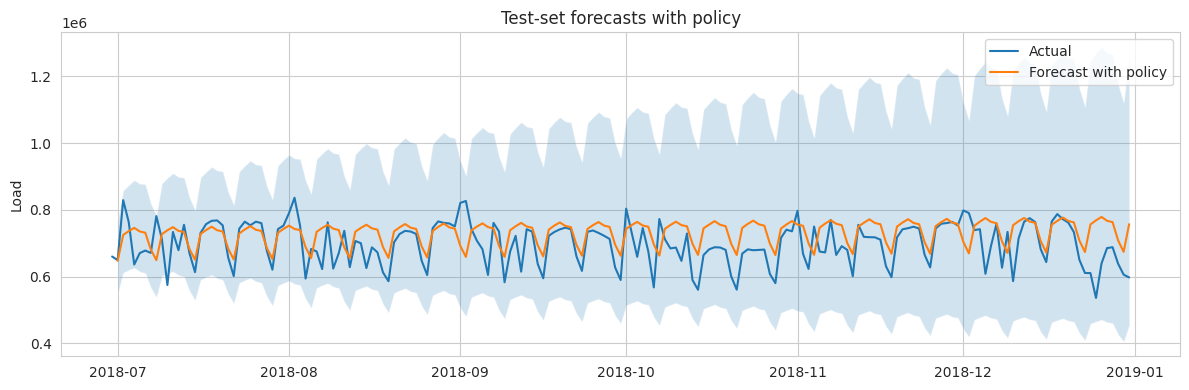

Average actual load: 696802.9162162162
Average forecast with policy: 730417.8625492862
Average forecast without policy: 903172.1269084964
Estimated average reduction (%): 19.12750174770534


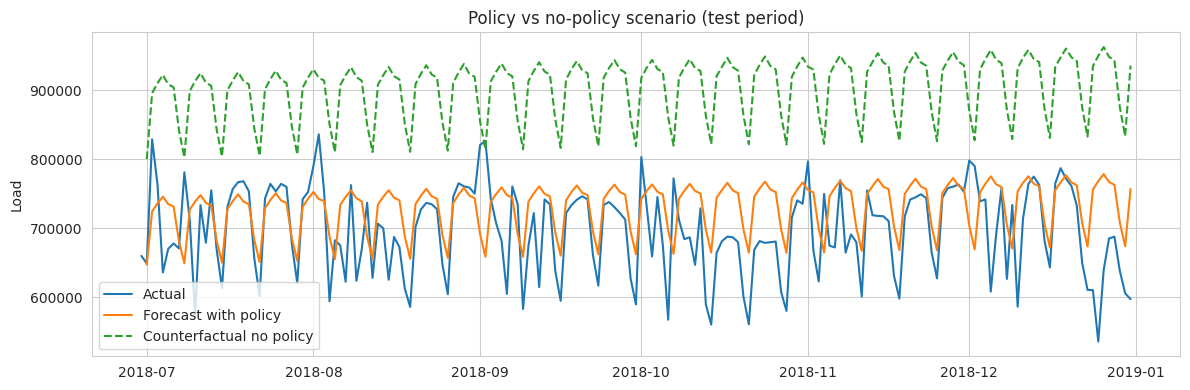

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

forecast_test = result_int.get_forecast(steps=len(y_test), exog=X_test)
pred_log = forecast_test.predicted_mean
ci_log = forecast_test.conf_int()

pred = np.exp(pred_log)
lower = np.exp(ci_log.iloc[:, 0])
upper = np.exp(ci_log.iloc[:, 1])
truth = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(truth, pred))
mape = mean_absolute_percentage_error(truth, pred)

print("Test RMSE:", rmse)
print("Test MAPE:", mape)

df_fc = pd.DataFrame(
    {
        "load_actual": truth,
        "load_forecast_policy": pred,
        "lower": lower,
        "upper": upper,
    },
    index=y_test.index,
)

plt.figure(figsize=(12, 4))
plt.plot(df_fc.index, df_fc["load_actual"], label="Actual")
plt.plot(df_fc.index, df_fc["load_forecast_policy"], label="Forecast with policy")
plt.fill_between(df_fc.index, df_fc["lower"], df_fc["upper"], alpha=0.2)
plt.title("Test-set forecasts with policy")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plt.show()

X_test_nopolicy = X_test.copy()
X_test_nopolicy["policy_step"] = 0
X_test_nopolicy["policy_pulse"] = 0

forecast_cf = result_int.get_forecast(steps=len(y_test), exog=X_test_nopolicy)
pred_cf_log = forecast_cf.predicted_mean
pred_cf = np.exp(pred_cf_log)

df_fc["load_forecast_no_policy"] = pred_cf

avg_actual = df_fc["load_actual"].mean()
avg_policy = df_fc["load_forecast_policy"].mean()
avg_cf = df_fc["load_forecast_no_policy"].mean()

print("Average actual load:", avg_actual)
print("Average forecast with policy:", avg_policy)
print("Average forecast without policy:", avg_cf)
print("Estimated average reduction (%):", (avg_cf - avg_policy) / avg_cf * 100)

plt.figure(figsize=(12, 4))
plt.plot(df_fc.index, df_fc["load_actual"], label="Actual")
plt.plot(df_fc.index, df_fc["load_forecast_policy"], label="Forecast with policy")
plt.plot(df_fc.index, df_fc["load_forecast_no_policy"], label="Counterfactual no policy", linestyle="--")
plt.title("Policy vs no-policy scenario (test period)")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plt.show()


Using the selected SARIMAX model, we generate one-step-ahead forecasts for the hold-out sample (July–December 2018). The model attains a test RMSE of about 76,000 and MAPE of roughly 8.7%, which indicates moderate but acceptable forecast accuracy for daily electricity demand.

To quantify the policy impact, we construct a counterfactual “no-policy” scenario by setting both intervention dummies to zero while keeping temperature unchanged. Over the test period, the mean predicted daily load under the no-policy scenario is approximately 903,000 MWh, compared with around 730,000 MWh under the policy scenario. This implies an estimated average reduction of about 19% in daily demand, consistent with the step coefficient in the regression.

The intervention model suggests that the assumed policy is associated with a large and statistically significant long-run reduction in electricity demand, on the order of 19%, after controlling for temperature and seasonal dynamics. The very short-run response on the implementation day is a small positive pulse, but it is quickly dominated by the sustained downward shift captured by the step dummy.

From a policy perspective, such a reduction indicates that demand-side measures (e.g. pricing reforms or conservation campaigns) can materially lower system load over time. Grid operators and regulators could use this type of intervention analysis to:

Evaluate alternative policy designs by comparing estimated long-run step effects.

Combine demand reductions with generation planning to defer capacity expansions.

Target further measures during peak seasons where residual spikes and forecast errors remain largest.

At the same time, future work could refine the model by including more detailed weather indicators, holiday dummies and explicit volatility models if residual heteroskedasticity becomes a concern.